In [5]:
import xarray as xr
import numpy as np
import datetime
import pandas as pd
from scipy import interpolate

import matplotlib as mpl
import matplotlib.pyplot as plt


import cartopy
import cartopy.feature as cfeat
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import xarray as xr
import numpy as np

from matplotlib import colors
from matplotlib import ticker
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.animation as animation
from IPython.display import HTML

import warnings; warnings.simplefilter('ignore')

In [6]:
# Coordinates for large regions. Position in
# (lon, lat): (rigth,  letf), (south, north),
# and title for an eventual ploting title.
reg_ext = {
    'lab': {
        'lon' : (-60, -30),
        'lat' : (50, 65),
        'name' : 'Labrador and Irminger Seas'
    },
    'gul': {
        'lon' : (-75, -45),
        'lat' : (30, 45),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-30, -5),
        'lat' : (45, 60),
        'name' : 'North East Sea'
    },
    'nor':{
        'lon' : (-30, 20.),
        'lat' : (60, 85),
        'name' : 'North Atlantic Ocean'
    },
    'noa':{
        'lon' : (-90, 15.),
        'lat' : (10, 85),
        'name' : 'North Atlantic Ocean'
    }
}

In [7]:
## Function to crop the dataset
def Crops(coord, d_set):
    """
        Crops is a function that takes a data set and crops it into smaller
        region, using as parameters the values given by the dictionary 
        reg_ext.
        
        Parameters:
        ------------
            
        coord : string
            Key value that identifies the region to obtain
        
        d_set : DataArray
            Dataset to be cropped
        
        Output:
        -------
        new_ds : DataArray
            New data array corresponding to the region stated by 'coord'
    """
    
    lon1, lon2 = reg_ext[coord]['lon']
    lat1, lat2 = reg_ext[coord]['lat']
    name_fig = reg_ext[coord]['name']
    
    new_ds = d_set.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2))
    return(new_ds)


def Grid(data_set):
    x = data_set.longitude
    y = data_set.latitude
    
    x, y = np.meshgrid(x, y)
    return(x, y)


def No_nan(a):
    """
        No_nan is a function that helps to filter an array from nan values.
        
        Parameters:
        ------------
        a : Numpy Array
            Is the array we want to filter
        
        Output:
        -------
        a2 : Numpy Arrray
            Array with no nan values in it
    """
    nan_array = np.isnan(a)
    not_nan_array = ~ nan_array
    a2 = a[not_nan_array]
    
    return(a2)


def Map(ax, region, xtik, ytik):
    ax.set_global()
    ax.coastlines('50m')
    ax.set_xticks(xtik, crs=ccrs.PlateCarree())
    ax.set_yticks(ytik, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.set_extent(region, crs=ccrs.PlateCarree())     #lat, lon
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, 
                 color='gray', alpha=0.5, linestyle='-.')



def Plot_Contours(data_set, reg, minl, maxl, nlevs, nlines, tstep=None, cmap=None):
    lon1, lon2 = reg_ext[reg]['lon']
    lat1, lat2 = reg_ext[reg]['lat']
    xtik = np.linspace(lon1, lon2, num=5)
    ytik = np.linspace(lat1, lat2, num=4)

    x_n, y_n = Grid(data_set)

    projection = ccrs.PlateCarree(360)
    region = [lon1, lon2, lat1, lat2]    #Lon, Lat
    
    if not cmap:
        cmap = 'magma_r'
    
    fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=projection), figsize=(10,5))    
    
    Map(ax, region, xtik, ytik)
    
    if tstep==None:
        contr1 = ax.contourf(x_n, y_n, data_set.mlotst, levels=np.linspace(minl, maxl, nlevs),
                                     cmap=cmap, extend='both')
        contr2 = ax.contour(x_n, y_n, data_set.zo[0], nlines, linewidths=0.5, colors='k')
        cbar = fig.colorbar(contr1, ax=ax, shrink=0.855, orientation='vertical',
                            label='MLD [m]', extend='both')  
        #cbar.set_clim(10,120)
    else:
        contr1 = ax.contourf(x_n, y_n, data_set.mlotst[tstep], levels=np.linspace(minl, maxl, nlevs),
                                     cmap=cmap, extend='both')
        contr2 = ax.contour(x_n, y_n, data_set.zo[tstep,0], nlines, linewidths=0.5, colors='k')
        cbar = fig.colorbar(contr1, ax=ax, shrink=0.855, orientation='vertical',
                            label='MLD [m]', extend='both')  
        #cbar.set_clim(10,120)

    #fig.savefig(os.path.abspath(os.path.sep.join([".","dummy_images","Noe_%0.4d.png" % it])))
    #plt.close(fig)
    plt.show()


def Masking(data_set, cond):
    """
        Maskin is a function that makes a mask of an array depending on the 
        entering condition. The condition is evaluated over finite numbers.
        At the final, the mask is appended in the original DataArray as a 
        new coordinate.
        
        Parameters:
        ------------
        data_set : DataArray
            Is the array we want to make the mask of.
            
        cond : array
            Codition to meet. 


        Output:
        -------
        data_set : Numpy Arrray
            Array with new coordinates 'mask'
    """
    
    mask = 1 * np.ones((data_set.dims['latitude'], data_set.dims['longitude'])) * np.isfinite(cond)  
    data_set.coords['mask'] = (('latitude', 'longitude'), mask)
    return(data_set)

In [8]:
###############################################################################
###########         MAIN PROGRAM
###############################################################################

dir_1 = '../../../New_ARMOR/'
dir_15 = '/net/data0-gw/data0/project/drakkar/USERS/lgarcia/data_ARMOR/'

dir_o = '/home/lgarcia/Documents/Scripts/Images_01/'

fl_n1 = 'NARMOR_*.nc'
fl_n15 = 'ARMOR_*.nc'


c_armor1 = xr.open_mfdataset(dir_1 + fl_n1, concat_dim='time')

c_armor15 = xr.open_mfdataset(dir_15 + fl_n15)
c_armor15 = Masking(c_armor15, c_armor15.to[0,18])   #For Nor::18, otherwise 25

d1 = datetime.datetime(2005,1,1)
d2 = datetime.datetime(2018,12,20)

weeks = pd.date_range(start=d1, end=d2, freq='7D')
c_armor1.coords['time'] = (('time'), weeks)

# Hovmoller kind plots to observe zonal/meridional changes in time

Here the objective is to see zonal or meridional variations of the MLD in time, for one year (2005) over the Gulf Stream. I present two plots for each year, mostly due the fact that the scale difference between the summer and winter times is a 'problem' that makes difficult to appreciate the changes, if we want to see all the year at the same time. All plots are done only for MLD. 

## Gulf Sream

In [5]:
reg = 'gul'
## File format :: t, lat, lon
gulf1 = Crops(reg, c_armor1)
gulf15 = Crops(reg, c_armor15)

gulf = gulf1.groupby('time.week').mean('time')

In [14]:
gulf

<xarray.Dataset>
Dimensions:    (latitude: 60, longitude: 120, week: 53)
Coordinates:
  * longitude  (longitude) float32 -74.875 -74.625 -74.375 ... -45.375 -45.125
  * latitude   (latitude) float32 30.125 30.375 30.625 ... 44.375 44.625 44.875
  * week       (week) int64 1 2 3 4 5 6 7 8 9 10 ... 45 46 47 48 49 50 51 52 53
Data variables:
    mlotst     (week, latitude, longitude) float64 dask.array<shape=(53, 60, 120), chunksize=(1, 60, 120)>

In [15]:
d1 = datetime.datetime(2000,1,1)
d2 = datetime.datetime(2000,12,31)
week2 = pd.date_range(start=d1, end=d2, freq='7D')

gulf.coords['week'] = (('week'), week2)

In [16]:
gulf

<xarray.Dataset>
Dimensions:    (latitude: 60, longitude: 120, week: 53)
Coordinates:
  * longitude  (longitude) float32 -74.875 -74.625 -74.375 ... -45.375 -45.125
  * latitude   (latitude) float32 30.125 30.375 30.625 ... 44.375 44.625 44.875
  * week       (week) datetime64[ns] 2000-01-01 2000-01-08 ... 2000-12-30
Data variables:
    mlotst     (week, latitude, longitude) float64 dask.array<shape=(53, 60, 120), chunksize=(1, 60, 120)>

In [17]:
stream = gulf15.sel(longitude=-60, method='nearest')

In [18]:
mean_stream = stream.groupby('time.week').mean(dim='time')

mean_stream.zo

<xarray.DataArray 'zo' (week: 53, depth: 33, latitude: 60)>
dask.array<shape=(53, 33, 60), dtype=float32, chunksize=(1, 33, 60)>
Coordinates:
  * depth      (depth) float64 0.0 10.0 20.0 30.0 ... 4.5e+03 5e+03 5.5e+03
  * latitude   (latitude) float32 30.125 30.375 30.625 ... 44.375 44.625 44.875
    longitude  float32 -59.875
    mask       (latitude) float64 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
  * week       (week) int64 1 2 3 4 5 6 7 8 9 10 ... 45 46 47 48 49 50 51 52 53

In [19]:
diff = mean_stream.differentiate('latitude')

In [20]:
dssh = diff.zo[:,0]

In [21]:
vals = dssh.groupby('week').argmin(dim='latitude', skipna=True)
vals

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


KeyboardInterrupt: 

In [ ]:
plt.close()
vals.plot()

In [17]:
vals.coords['week'] = (('week'), week2)

In [18]:
diff.isel(latitude=0).values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:    (depth: 33, week: 53)
Coordinates:
  * depth      (depth) float64 0.0 10.0 20.0 30.0 ... 4.5e+03 5e+03 5.5e+03
    latitude   float32 30.125
    longitude  float32 -59.875
    mask       float64 1.0
  * week       (week) int64 1 2 3 4 5 6 7 8 9 10 ... 45 46 47 48 49 50 51 52 53
Data variables:
    mlotst     (week) float64 dask.array<shape=(53,), chunksize=(1,)>
    so         (week, depth) float64 dask.array<shape=(53, 33), chunksize=(1, 33)>
    to         (week, depth) float64 dask.array<shape=(53, 33), chunksize=(1, 33)>
    ugo        (week, depth) float64 dask.array<shape=(53, 33), chunksize=(1, 33)>
    vgo        (week, depth) float64 dask.array<shape=(53, 33), chunksize=(1, 33)>
    zo         (week, depth) float64 dask.array<shape=(53, 33), chunksize=(1, 33)>>

## Zonal variations

### Zonal Mean MLD

In [19]:
zonal_mean = gulf.where(gulf15.mask==1).mean(dim='longitude', skipna=True)
zonal_std = gulf.where(gulf15.mask==1).std(dim='longitude', skipna=True)

part1 = zonal_mean.isel(week=slice(0,26))
part2 = zonal_mean.isel(week=slice(26, 53))
ps1 = zonal_std.isel(week=slice(0,26))
ps2 = zonal_std.isel(week=slice(26, 53))

ssh1 = vals.isel(week=slice(0,26))
ssh2 = vals.isel(week=slice(26, 53))

In [20]:
n = xr.concat([part2, part1], dim='week')
n2 = xr.concat([ps2, ps1], dim='week')
ssh = xr.concat([ssh2, ssh1], dim='week')

In [ ]:
ssh

In [21]:
months = ['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 
          'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', ]

In [22]:
 n.latitude.values

l = [ lat for lat in n.latitude.values]

In [ ]:
%matplotlib notebook

plt.close()

x = pd.to_datetime(n.week.values)
y =  n.latitude.values
#X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots()

cs = ax.contourf(n.mlotst.T, levels=np.linspace(10., 130., 15), cmap='plasma')
ax.plot(ssh.T, linewidth=2, color='w')
#cs2 = ax.contour(n2.mlotst.T, 20, linewidths=0.5, colors='k')
#ax.set_xlabel('time [weeks]')
#ax.set_ylabel('MLD [m]')
#ax.set_title('Gulf Stream MLD distribution')
cb = fig.colorbar(cs, ax=ax, orientation='vertical')

plt.xticks(np.arange(n.week.size, step=4.5), months, rotation=20)
plt.yticks(np.arange(len(l), step=5), l[::5])
plt.yax

.set_major_formatter(ticker.FormatStrFormatter('%0.0e'))

plt.xlabel('Month')
plt.ylabel('Latitude')

plt.title('MLD zonal mean\nGulf Stream')

cb.set_label('MLD [m]')
plt.savefig(dir_o + 'Gul-Zonal-MLD-Hov.png.png', bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


### Zonal standar deviation

<IPython.core.display.Javascript object>


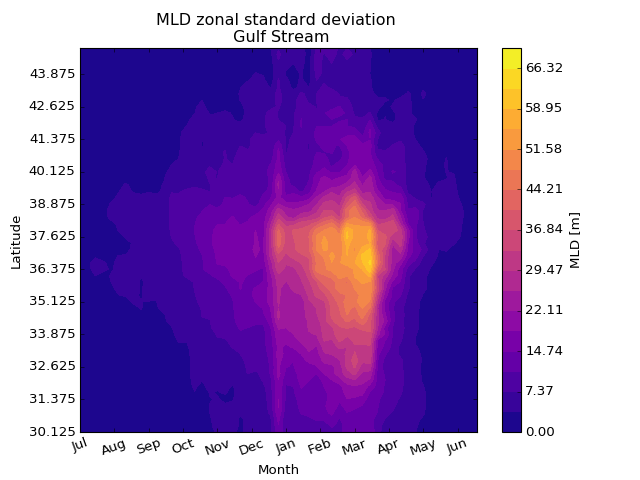

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


In [346]:
%matplotlib notebook

plt.close()

x = pd.to_datetime(n2.week.values)
y =  n.latitude.values
#X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots()

cs = ax.contourf(n2.mlotst.T, levels=np.linspace(0., 70., 15), cmap='plasma')
#ax.set_xlabel('time [weeks]')
#ax.set_ylabel('MLD [m]')
#ax.set_title('Gulf Stream MLD distribution')
cb = fig.colorbar(cs, ax=ax, orientation='vertical')

plt.xticks(np.arange(n2.week.size, step=4.5), months, rotation=20)
plt.yticks(np.arange(len(l), step=5), l[::5])

plt.xlabel('Month')
plt.ylabel('Latitude')

plt.title('MLD zonal standard deviation \n Gulf Stream')

cb.set_label('MLD [m]')
plt.savefig(dir_o + 'Gul-PDF-Seasonal-STD-Hov.png', bbox_inches='tight')
plt.show()

In [337]:
n.mlotst.max(skipna=True).values

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


array(127.95119048)

## Labrador-Irminger

In [22]:
reg = 'lab'
## File format :: t, lat, lon
lab1 = Crops(reg, c_armor1)
lab15 = Crops(reg, c_armor15)

lab = lab1.groupby('time.week').mean('time')

In [23]:
lab

<xarray.Dataset>
Dimensions:    (latitude: 60, longitude: 120, week: 53)
Coordinates:
  * longitude  (longitude) float32 -59.875 -59.625 -59.375 ... -30.375 -30.125
  * latitude   (latitude) float32 50.125 50.375 50.625 ... 64.375 64.625 64.875
  * week       (week) int64 1 2 3 4 5 6 7 8 9 10 ... 45 46 47 48 49 50 51 52 53
Data variables:
    mlotst     (week, latitude, longitude) float64 dask.array<shape=(53, 60, 120), chunksize=(1, 60, 120)>

In [24]:
d1 = datetime.datetime(2000,1,1)
d2 = datetime.datetime(2000,12,31)
week2 = pd.date_range(start=d1, end=d2, freq='7D')

lab.coords['week'] = (('week'), week2)

In [25]:
lab

<xarray.Dataset>
Dimensions:    (latitude: 60, longitude: 120, week: 53)
Coordinates:
  * longitude  (longitude) float32 -59.875 -59.625 -59.375 ... -30.375 -30.125
  * latitude   (latitude) float32 50.125 50.375 50.625 ... 64.375 64.625 64.875
  * week       (week) datetime64[ns] 2000-01-01 2000-01-08 ... 2000-12-30
Data variables:
    mlotst     (week, latitude, longitude) float64 dask.array<shape=(53, 60, 120), chunksize=(1, 60, 120)>

## Zonal variations

### Zonal Mean MLD

In [33]:
zonal_mean = lab.where(lab15.mask==1).mean(dim='longitude', skipna=True)
zonal_std = lab.where(lab15.mask==1).std(dim='longitude', skipna=True)

part1 = zonal_mean.isel(week=slice(0,26))
part2 = zonal_mean.isel(week=slice(26, 53))
ps1 = zonal_std.isel(week=slice(0,26))
ps2 = zonal_std.isel(week=slice(26, 53))

In [34]:
n = xr.concat([part2, part1], dim='week')
n2 = xr.concat([ps2, ps1], dim='week')


In [35]:
n.mlotst.max(skipna=True).values

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


array(330.34571623)

In [26]:
months = ['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 
          'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', ]

In [27]:
 n.latitude.values

l = [ lat for lat in n.latitude.values]

In [ ]:
%matplotlib notebook

plt.close()

x = pd.to_datetime(n.week.values)
y =  n.latitude.values
#X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots()

cs = ax.contourf(n.mlotst.T, levels=np.linspace(10., 340., 15), cmap='plasma')
#ax.plot(ssh.T, linewidth=2, color='w')
#cs2 = ax.contour(n2.mlotst.T, 20, linewidths=0.5, colors='k')
#ax.set_xlabel('time [weeks]')
#ax.set_ylabel('MLD [m]')
#ax.set_title('Gulf Stream MLD distribution')
cb = fig.colorbar(cs, ax=ax, orientation='vertical')

plt.xticks(np.arange(n.week.size, step=4.5), months, rotation=20)
plt.yticks(np.arange(len(l), step=5), l[::5])

plt.xlabel('Month')
plt.ylabel('Latitude')

plt.title('MLD zonal mean \n Labrador and Irminger Seas')

cb.set_label('MLD [m]')
plt.savefig(dir_o + 'Lab-Zonal-MLD-Hov.png', bbox_inches='tight')
plt.show()

### Zonal standar deviation

<IPython.core.display.Javascript object>


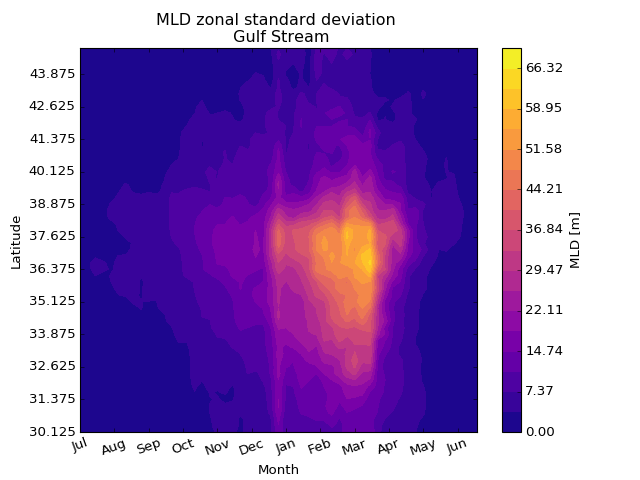

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


In [346]:
%matplotlib notebook

plt.close()

x = pd.to_datetime(n2.week.values)
y =  n.latitude.values
#X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots()

cs = ax.contourf(n2.mlotst.T, levels=np.linspace(0., 70., 20), cmap='plasma')
#ax.set_xlabel('time [weeks]')
#ax.set_ylabel('MLD [m]')
#ax.set_title('Gulf Stream MLD distribution')
cb = fig.colorbar(cs, ax=ax, orientation='vertical')

plt.xticks(np.arange(n2.week.size, step=4.5), months, rotation=15)
plt.yticks(np.arange(len(l), step=5), l[::5])

plt.xlabel('Month')
plt.ylabel('Latitude')

plt.title('MLD zonal standard deviation \n Labrador and Irminger Seas')

cb.set_label('MLD [m]')
#plt.savefig(dir_o + 'Gul-PDF-Seasonal-STD-Hov.png', bbox_inches='tight')
plt.show()

In [337]:
n.mlotst.max(skipna=True).values

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


array(127.95119048)

### Meridional mean

In [36]:
merid_mean = lab.where(lab15.mask==1).mean(dim='latitude', skipna=True)
merid_std = lab.where(lab15.mask==1).std(dim='latitude', skipna=True)

merid_mean

<xarray.Dataset>
Dimensions:    (longitude: 120, week: 53)
Coordinates:
  * longitude  (longitude) float32 -59.875 -59.625 -59.375 ... -30.375 -30.125
  * week       (week) datetime64[ns] 2000-01-01 2000-01-08 ... 2000-12-30
Data variables:
    mlotst     (week, longitude) float64 dask.array<shape=(53, 120), chunksize=(1, 120)>

In [37]:
part1 = merid_mean.isel(week=slice(0,26))
part2 = merid_mean.isel(week=slice(26, 53))
ps1 = merid_std.isel(week=slice(0,26))
ps2 = merid_std.isel(week=slice(26, 53))

In [38]:
n_m = xr.concat([part2, part1], dim='week')
n2_m = xr.concat([ps2, ps1], dim='week')

n_m

<xarray.Dataset>
Dimensions:    (longitude: 120, week: 53)
Coordinates:
  * longitude  (longitude) float32 -59.875 -59.625 -59.375 ... -30.375 -30.125
  * week       (week) datetime64[ns] 2000-07-01 2000-07-08 ... 2000-06-24
Data variables:
    mlotst     (week, longitude) float64 dask.array<shape=(53, 120), chunksize=(1, 120)>

In [39]:
n_m.mlotst.max(skipna=True).values

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


array(258.86253369)

In [40]:
months = ['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 
          'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', ]

In [42]:
n_m.lo

<xarray.Dataset>
Dimensions:    (longitude: 120, week: 53)
Coordinates:
  * longitude  (longitude) float32 -59.875 -59.625 -59.375 ... -30.375 -30.125
  * week       (week) datetime64[ns] 2000-07-01 2000-07-08 ... 2000-06-24
Data variables:
    mlotst     (week, longitude) float64 dask.array<shape=(53, 120), chunksize=(1, 120)>

In [43]:
n_m.longitude.values

l = [ lat for lat in n_m.longitude.values]

In [59]:
def major_formatter(x, pos):
    return "[%.0f]" % x

<IPython.core.display.Javascript object>


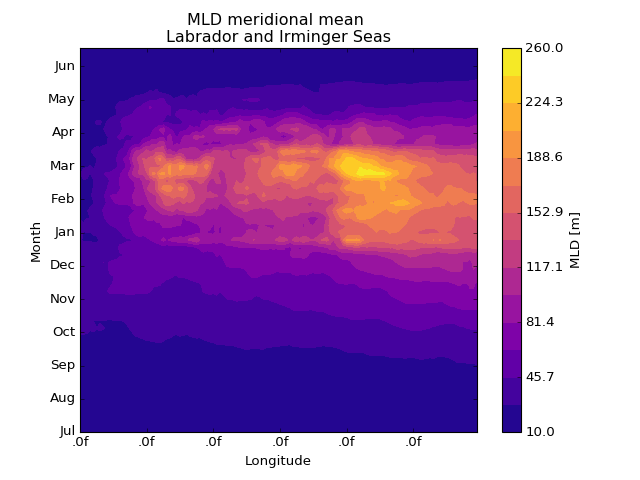

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


In [61]:
%matplotlib notebook

plt.close()

x = n_m.week
y =  n_m.longitude
#X, Y = np.meshgrid(y, x)

fig, ax = plt.subplots()

cs = ax.contourf(n_m.mlotst, levels=np.linspace(10., 260., 15), cmap='plasma')
#ax.plot(ssh.T, linewidth=2, color='w')
#cs2 = ax.contour(n2.mlotst.T, 20, linewidths=0.5, colors='k')
#ax.set_xlabel('time [weeks]')
#ax.set_ylabel('MLD [m]')
#ax.set_title('Gulf Stream MLD distribution')
cb = fig.colorbar(cs, ax=ax, orientation='vertical')

plt.yticks(np.arange(n.week.size, step=4.5), months, rotation=0)
#plt.xticks(np.arange(len(l), step=20), l[::20], rotation=20)
ax.xaxis.set_major_formatter(ticker.FixedFormatter(l[::20]))



formatter = ticker.FormatStrFormatter('.0f')
ax.xaxis.set_major_formatter(formatter)


plt.ylabel('Month')
plt.xlabel('Longitude')

plt.title('MLD meridional mean \nLabrador and Irminger Seas')

cb.set_label('MLD [m]')
#plt.savefig(dir_o + 'Lab-Meridional-MLD-Hov.png', bbox_inches='tight')
plt.show()

## North East

In [79]:
reg = 'noe'
## File format :: t, lat, lon
noe1 = Crops(reg, c_armor1)
noe15 = Crops(reg, c_armor15)

noe = noe1.groupby('time.week').mean('time')

In [34]:
noe

<xarray.Dataset>
Dimensions:    (latitude: 60, longitude: 100, week: 53)
Coordinates:
  * longitude  (longitude) float32 -29.875 -29.625 -29.375 ... -5.375 -5.125
  * latitude   (latitude) float32 45.125 45.375 45.625 ... 59.375 59.625 59.875
  * week       (week) int64 1 2 3 4 5 6 7 8 9 10 ... 45 46 47 48 49 50 51 52 53
Data variables:
    mlotst     (week, latitude, longitude) float64 dask.array<shape=(53, 60, 100), chunksize=(1, 60, 100)>

In [80]:
d1 = datetime.datetime(2000,1,1)
d2 = datetime.datetime(2000,12,31)
week2 = pd.date_range(start=d1, end=d2, freq='7D')

noe.coords['week'] = (('week'), week2)

In [36]:
noe

<xarray.Dataset>
Dimensions:    (latitude: 60, longitude: 100, week: 53)
Coordinates:
  * longitude  (longitude) float32 -29.875 -29.625 -29.375 ... -5.375 -5.125
  * latitude   (latitude) float32 45.125 45.375 45.625 ... 59.375 59.625 59.875
  * week       (week) datetime64[ns] 2000-01-01 2000-01-08 ... 2000-12-30
Data variables:
    mlotst     (week, latitude, longitude) float64 dask.array<shape=(53, 60, 100), chunksize=(1, 60, 100)>

## Zonal variations

### Zonal Mean MLD

In [81]:
zonal_mean = noe.where(noe15.mask==1).mean(dim='longitude', skipna=True)
zonal_std = noe.where(noe15.mask==1).std(dim='longitude', skipna=True)

part1 = zonal_mean.isel(week=slice(0,26))
part2 = zonal_mean.isel(week=slice(26, 53))
ps1 = zonal_std.isel(week=slice(0,26))
ps2 = zonal_std.isel(week=slice(26, 53))

In [82]:
n = xr.concat([part2, part1], dim='week')
n2 = xr.concat([ps2, ps1], dim='week')

n.mlotst.max(skipna=True).values

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


array(322.84231806)

In [83]:
months = ['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 
          'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', ]

In [84]:
 n.latitude.values

l = [ lat for lat in n.latitude.values]

<IPython.core.display.Javascript object>


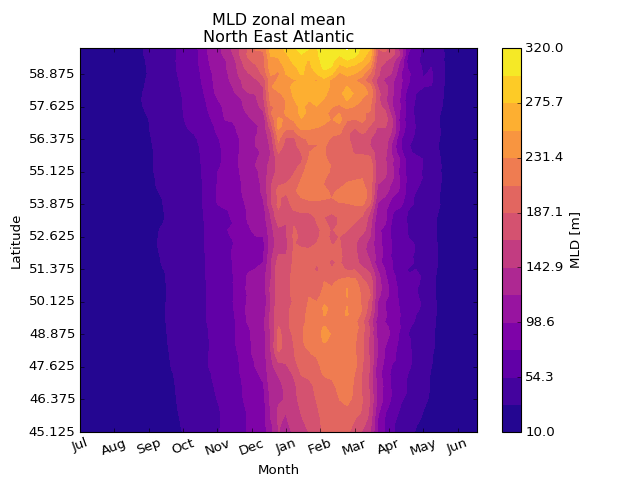

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


In [87]:
%matplotlib notebook

plt.close()

x = pd.to_datetime(n.week.values)
y =  n.latitude.values
#X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots()

cs = ax.contourf(n.mlotst.T, levels=np.linspace(10., 320., 15), cmap='plasma')
#ax.plot(ssh.T, linewidth=2, color='w')
#cs2 = ax.contour(n2.mlotst.T, 20, linewidths=0.5, colors='k')
#ax.set_xlabel('time [weeks]')
#ax.set_ylabel('MLD [m]')
#ax.set_title('Gulf Stream MLD distribution')
cb = fig.colorbar(cs, ax=ax, orientation='vertical')

plt.xticks(np.arange(n.week.size, step=4.5), months, rotation=20)
plt.yticks(np.arange(len(l), step=5), l[::5])

plt.xlabel('Month')
plt.ylabel('Latitude')

plt.title('MLD zonal mean\nNorth East Atlantic')

cb.set_label('MLD [m]')
plt.savefig(dir_o + 'Noe-Zonal-MLD-Hov.png.png', bbox_inches='tight')
plt.show()

### Zonal standar deviation

<IPython.core.display.Javascript object>


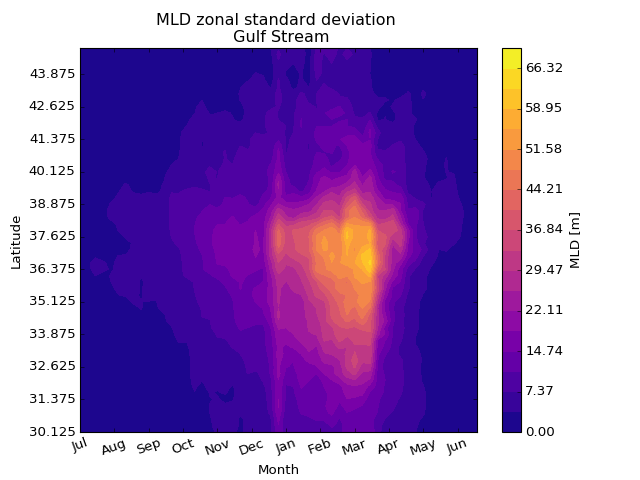

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


In [346]:
%matplotlib notebook

plt.close()

x = pd.to_datetime(n2.week.values)
y =  n.latitude.values
#X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots()

cs = ax.contourf(n2.mlotst.T, levels=np.linspace(0., 70., 20), cmap='plasma')
#ax.set_xlabel('time [weeks]')
#ax.set_ylabel('MLD [m]')
#ax.set_title('Gulf Stream MLD distribution')
cb = fig.colorbar(cs, ax=ax, orientation='vertical')

plt.xticks(np.arange(n2.week.size, step=4.5), months, rotation=20)
plt.yticks(np.arange(len(l), step=5), l[::5])

plt.xlabel('Month')
plt.ylabel('Latitude')

plt.title('MLD zonal standard deviation \n Gulf Stream')

cb.set_label('MLD [m]')
plt.savefig(dir_o + 'Gul-PDF-Seasonal-STD-Hov.png', bbox_inches='tight')
plt.show()

In [337]:
n.mlotst.max(skipna=True).values

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


array(127.95119048)

## Nordic Sea

In [9]:
reg = 'nor'
## File format :: t, lat, lon
nor1 = Crops(reg, c_armor1)
nor15 = Crops(reg, c_armor15)

nor = nor1.groupby('time.week').mean('time')

In [10]:
nor

<xarray.Dataset>
Dimensions:    (latitude: 100, longitude: 200, week: 53)
Coordinates:
  * longitude  (longitude) float32 -29.875 -29.625 -29.375 ... 19.625 19.875
  * latitude   (latitude) float32 60.125 60.375 60.625 ... 84.375 84.625 84.875
  * week       (week) int64 1 2 3 4 5 6 7 8 9 10 ... 45 46 47 48 49 50 51 52 53
Data variables:
    mlotst     (week, latitude, longitude) float64 dask.array<shape=(53, 100, 200), chunksize=(1, 100, 200)>

In [11]:
d1 = datetime.datetime(2000,1,1)
d2 = datetime.datetime(2000,12,31)
week2 = pd.date_range(start=d1, end=d2, freq='7D')

nor.coords['week'] = (('week'), week2)

In [12]:
nor

<xarray.Dataset>
Dimensions:    (latitude: 100, longitude: 200, week: 53)
Coordinates:
  * longitude  (longitude) float32 -29.875 -29.625 -29.375 ... 19.625 19.875
  * latitude   (latitude) float32 60.125 60.375 60.625 ... 84.375 84.625 84.875
  * week       (week) datetime64[ns] 2000-01-01 2000-01-08 ... 2000-12-30
Data variables:
    mlotst     (week, latitude, longitude) float64 dask.array<shape=(53, 100, 200), chunksize=(1, 100, 200)>

## Zonal variations

### Zonal Mean MLD

In [13]:
zonal_mean = nor.where(nor15.mask==1).mean(dim='longitude', skipna=True)
zonal_std = nor.where(nor15.mask==1).std(dim='longitude', skipna=True)

part1 = zonal_mean.isel(week=slice(0,26))
part2 = zonal_mean.isel(week=slice(26, 53))
ps1 = zonal_std.isel(week=slice(0,26))
ps2 = zonal_std.isel(week=slice(26, 53))

In [14]:
n = xr.concat([part2, part1], dim='week')
n2 = xr.concat([ps2, ps1], dim='week')

n.mlotst.max(skipna=True).values

array(346.11729323)

In [15]:
months = ['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 
          'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', ]

In [16]:
l = [ lat for lat in n.latitude.values]

<IPython.core.display.Javascript object>


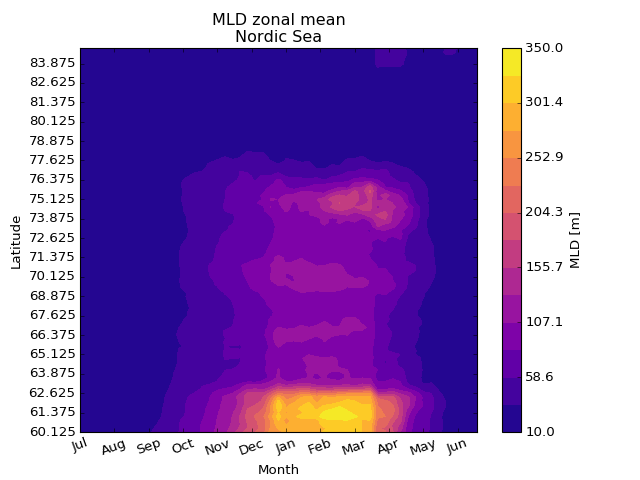

In [18]:
%matplotlib notebook

plt.close()

x = pd.to_datetime(n.week.values)
y =  n.latitude.values
#X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots()

cs = ax.contourf(n.mlotst.T, levels=np.linspace(10., 350., 15), cmap='plasma')
cb = fig.colorbar(cs, ax=ax, orientation='vertical')

plt.xticks(np.arange(n.week.size, step=4.5), months, rotation=20)
plt.yticks(np.arange(len(l), step=5), l[::5])

plt.xlabel('Month')
plt.ylabel('Latitude')

plt.title('MLD zonal mean\nNordic Sea')

cb.set_label('MLD [m]')
plt.savefig(dir_o + 'Nor-Zonal-MLD-Hov.png.png', bbox_inches='tight')
plt.show()

### Zonal standar deviation

<IPython.core.display.Javascript object>


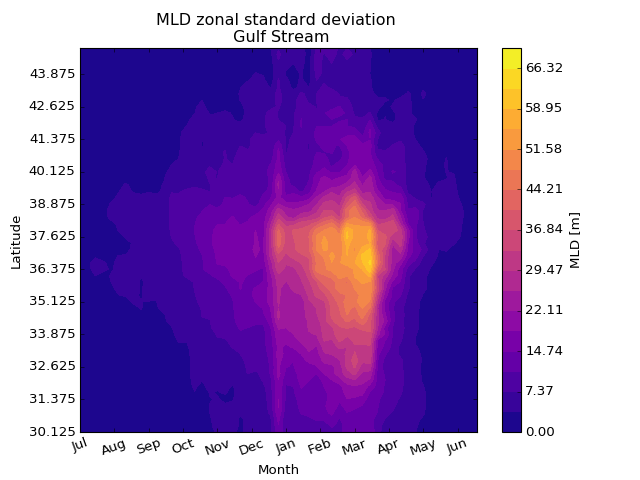

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


In [346]:
%matplotlib notebook

plt.close()

x = pd.to_datetime(n2.week.values)
y =  n.latitude.values
#X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots()

cs = ax.contourf(n2.mlotst.T, levels=np.linspace(0., 70., 20), cmap='plasma')
#ax.set_xlabel('time [weeks]')
#ax.set_ylabel('MLD [m]')
#ax.set_title('Gulf Stream MLD distribution')
cb = fig.colorbar(cs, ax=ax, orientation='vertical')

plt.xticks(np.arange(n2.week.size, step=4.5), months, rotation=20)
plt.yticks(np.arange(len(l), step=5), l[::5])

plt.xlabel('Month')
plt.ylabel('Latitude')

plt.title('MLD zonal standard deviation \n Gulf Stream')

cb.set_label('MLD [m]')
plt.savefig(dir_o + 'Gul-PDF-Seasonal-STD-Hov.png', bbox_inches='tight')
plt.show()

In [337]:
n.mlotst.max(skipna=True).values

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


array(127.95119048)